# Language Model Training and Transfer Learning
This notebook shows how to create and train a language model as well as how to reuse parts of it for a new task.  In our case we will try the IMDB task again, as well as a new task which attempts to classify the ratings of Rotten Tomatoes reviews.

In [1]:
import os, json, pickle
from collections import Counter

In [2]:
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [3]:
import numpy as np
from scipy.sparse import csr_matrix, vstack, lil_matrix

In [4]:
import h5py

### Create Training Data

We set up on Amazon review data in this section.  The review gets tokenized and turned into an integer representation, and then saved to an HDF5 file.

In [5]:
with open('vocab_count.pkl', 'rb') as f:
    vocab_count = pickle.load(f)

In [6]:
VOCAB_LIMIT = 100000
VOCAB_FREQ_MIN = 2
MAX_LEN = 250

In [7]:
vocab_list = [o for o, c in vocab_count.most_common(VOCAB_LIMIT-2) if c > VOCAB_FREQ_MIN]
vocab_list.insert(0, '<unk>')
vocab_list.insert(0, '<pad>')
int2word_hash = {i:w for i, w in enumerate(vocab_list)}
word2int_hash = {v:k for k, v in int2word_hash.items()}

In [ ]:
with open('data/amazon/movie_review_tokenized.json', 'r') as in_file:
    completed_reviews = 0
    for line in in_file:
        if completed_reviews > 500000:
            break
        review = json.loads(line)
        review_text = review['reviewTextTokenized']
        hashed_review = [word2int_hash.get(x,1) if word2int_hash.get(x,1) < VOCAB_LIMIT-2 else 1 for x in review_text]
        h5_file = h5py.File('data/language_pkl/amazon_language_data.h5','a')
        h5_file.create_dataset('amazon_lm_'+str(completed_reviews), data=hashed_review)
        h5_file.close()
        completed_reviews += 1
        if completed_reviews % 10000 == 0:
            print('Completed: {}'.format(completed_reviews))

### Create Word Embeddings

In this step, we load the word embeddings created in the previous notebook using the IMDB and Amazon data.

In [8]:
from gensim.models import Word2Vec

In [9]:
wv_model = Word2Vec.load('data/w2v_192_language_model_tokens_')

In [10]:
def create_embedding_matrix(wv_model, index_word_dict, max_len=None, verbose=False):
    EMBED_SIZE = wv_model.vector_size
    unknown_word_count = 0
    unknown_word_list = list()
    
    def choose_embedded_vector(wv_model, word, unknown_word_count, verbose=verbose):
        if word in wv_model.wv.vocab:
            return wv_model.wv.word_vec(word), unknown_word_count
        else:
            if verbose:
                unknown_word_list.append(word)
            return np.random.uniform(low=-.05, high=.05, size=EMBED_SIZE), (unknown_word_count+1)

    word_index_dict = {v:k for k, v in index_word_dict.items()}
    num_words = len(index_word_dict)


    embedding_weights = np.zeros((num_words, EMBED_SIZE))
    for word, index in word_index_dict.items():
        embedding_weights[index,:], unknown_word_count = choose_embedded_vector(wv_model, word, unknown_word_count, verbose=verbose)
    
    if verbose:
        print('The size of the data token vocab is: {}'.format(num_words))
        print('The size of the word vector vocab is: {}'.format(EMBED_SIZE))
        print('Embedding matrix shape: {}'.format(embedding_weights.shape))
        print('Total amount of words not found in gensim word2vec model: {}'.format(unknown_word_count))
        print('The words not found in gensim word2vec model: {}'.format(str(unknown_word_list)))
        
    
    return embedding_weights

In [11]:
embedding_weights = create_embedding_matrix(wv_model, int2word_hash, max_len=None, verbose=True)

The size of the data token vocab is: 100000
The size of the word vector vocab is: 192
Embedding matrix shape: (100000, 192)
Total amount of words not found in gensim word2vec model: 2
The words not found in gensim word2vec model: ['<pad>', '<unk>']


### Create Batch Generator

Because our data is too big to put in memory, we have to read it in batches from disk.  Keras has a special type of fitting function called fit_generator that allows us to pass in a generator instead of an object in memory.  This section creates the generator that eventually yields the X and y for training.

In [12]:
from random import shuffle
from scipy.sparse import vstack

In [13]:
def create_fwd_target_matrix(s):
    rolled_review = np.roll(s, -1)
    rolled_review[-1] = 0
    tmp = lil_matrix((rolled_review.shape[0], VOCAB_LIMIT))
    for i, w in enumerate(s):
        tmp[i,w] = 1
    return tmp

In [14]:
def batch_generator(hdf5_file_location, batch_size):
    hf = h5py.File(hdf5_file_location, 'r')
    hf_dataset_names = list(hf.keys())
    
    samples_per_epoch = len(hf_dataset_names)
    number_of_batches = int(samples_per_epoch / batch_size)
    counter = 0
    
    shuffle(hf_dataset_names)
    
    while True:
        index_batch = hf_dataset_names[batch_size*counter:batch_size*(counter+1)]
        batch_list = list()
        for f in index_batch:
            batch_list.append(pad_sequences([hf.get(f).value], maxlen=MAX_LEN)[0])
        X_batch = np.vstack(batch_list)
        y_forward_batch = np.reshape(np.array(np.vstack([create_fwd_target_matrix(x).todense() for x in X_batch])), (batch_size, MAX_LEN, -1))
        y_backward_batch = np.flip(np.roll(y_forward_batch, 2, axis=1), axis=1)
        counter += 1
        yield(X_batch, [y_forward_batch, y_backward_batch])
        
        if (counter < number_of_batches):
            shuffle(hf_dataset_names)
            counter=0

### Create Language Model

This section creates and trains the language model.  Since we have so much data, one single pass through the reviews is sufficient.  Fair waring, this will take about 24-48 hours to train depending on your compute resources and GPU size.

In [12]:
from keras.models import Model, load_model
from keras.regularizers import l2
from keras import initializers, regularizers, constraints
from keras.layers import Layer, Input, Embedding, Dropout, Conv1D, concatenate, LSTM, TimeDistributed, Dense, Add, GlobalMaxPool1D, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam, SGD
from keras import backend as K 

In [13]:
EMBED_SIZE = wv_model.vector_size
CNN_FILTER_SIZE = 96
CNN_KERNEL_SIZE_1 = 3
CNN_KERNEL_SIZE_2 = 4
CNN_KERNEL_SIZE_3 = 5
LSTM_HIDDEN = 64
VOCAB_SIZE = len(int2word_hash)

def get_language_model():    
    input_text = Input(shape=(MAX_LEN, ))
    x = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_LEN, weights=[embedding_weights], mask_zero=False, trainable=False, name='word_embeddings')(input_text)
    x = Dropout(0.5)(x)
    c1 = Conv1D(filters=CNN_FILTER_SIZE, kernel_size=CNN_KERNEL_SIZE_1, padding='same', kernel_regularizer=l2(0.001))(x)
    c2 = Conv1D(filters=CNN_FILTER_SIZE, kernel_size=CNN_KERNEL_SIZE_2, padding='same', kernel_regularizer=l2(0.001))(x)
    c3 = Conv1D(filters=CNN_FILTER_SIZE, kernel_size=CNN_KERNEL_SIZE_3, padding='same', kernel_regularizer=l2(0.001))(x)
    x = concatenate([c1,c2,c3])
    
    l_f = LSTM(LSTM_HIDDEN,
               return_sequences=True,
               return_state=False,
               kernel_regularizer=l2(0.001),
               recurrent_regularizer=l2(0.001))(x)
    
    output_f = TimeDistributed(Dense(VOCAB_SIZE, activation="softmax"))(l_f)
    
    l_b = LSTM(LSTM_HIDDEN,
               return_sequences=True,
               return_state=False,
               kernel_regularizer=l2(0.001),
               recurrent_regularizer=l2(0.001),
               go_backwards=True)(x)
    
    output_b = TimeDistributed(Dense(VOCAB_SIZE, activation="softmax"))(l_b)
    
    opt = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    model = Model(inputs=[input_text], outputs=[output_f, output_b])
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [14]:
model = get_language_model()

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
word_embeddings (Embedding)     (None, 250, 192)     19200000    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 250, 192)     0           word_embeddings[0][0]            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 250, 96)      55392       dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

In [18]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [19]:
hf = h5py.File('data/language_pkl/amazon_language_data.h5', 'r')
hf_dataset_names = list(hf.keys())

In [20]:
BATCH_SIZE = 8
EPOCHS = 1
STEPS_PER_EPOCH = int(len(hf_dataset_names) / BATCH_SIZE)
VAL_STEPS = int(len(hf_dataset_names) / BATCH_SIZE)
MODEL_NAME = 'language_model_bidirectional'
FILE_PATH = "../models/language_model_bidirectional.hdf5"
checkpoint = ModelCheckpoint(FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=2)
tensorboard = TensorBoard(log_dir='/home/ml-notebooks/models/tensorboard/{}'.format(MODEL_NAME), 
                          batch_size=BATCH_SIZE)
callbacks_list = [checkpoint, early]

In [21]:
model.fit_generator(generator = batch_generator('data/language_pkl/amazon_language_data.h5', BATCH_SIZE),
                    steps_per_epoch = STEPS_PER_EPOCH,
                    epochs = EPOCHS)

Epoch 1/1
 9676/31060 [========>.....................] - ETA: 17:16:27 - loss: 4.8825 - time_distributed_1_loss: 1.5027 - time_distributed_2_loss: 3.2291 - time_distributed_1_acc: 0.8080 - time_distributed_2_acc: 0.5425

KeyboardInterrupt: 

In [22]:
model.save('data/lm_amazon_reviews_250k.hdf5')

In [24]:
text_review = ["<sos>", "this", "is", "a", "charming", "version", "of", "the", "classic", "dicken", "'s", "tale", ".", "henry", "winkler", "makes", "a", "good", "showing", "as", "the", "scrooge", "character", ".", "even", "though", "you", "know", "what", "will", "happen", "this", "version", "has", "enough", "of", "a", "change", "to", "make", "it", "better", "that", "average", ".", "if", "you", "love", "a", "christmas", "carol", "in", "any", "version", ",", "then", "you", "will", "love", "this", ".", "<eos>"]

In [36]:
' '.join(text_review)

"<sos> this is a charming version of the classic dicken 's tale . henry winkler makes a good showing as the scrooge character . even though you know what will happen this version has enough of a change to make it better that average . if you love a christmas carol in any version , then you will love this . <eos>"

In [25]:
text_review_hashed = [word2int_hash.get(x,1) for x in text_review]
text_review_pad = pad_sequences([text_review_hashed], maxlen=MAX_LEN)
text_hat = model.predict(text_review_pad)

In [43]:
' '.join([int2word_hash.get(x,0) for x in np.argmax(text_hat[0][0], axis=1) if x != 0])

"<sos> this is a charming version of the classic disney 's tale . henry nicholson makes a good showing as the character . even though you know what will happen this version has enough of a change to make it better that average . if you love a christmas carol in any version , then you will love this . <eos>"

### Transfer Learning: Prep Classification Data

In this section we prepare our data for training a new sentiment model.  We prep both the IMDB and Rotten Tomatoes data.

#### IMDB Data

In [53]:
import pandas as pd
import re
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [13]:
TRAIN_DATA_FOLDER = 'data/aclImdb/train/'
TEST_DATA_FOLDER = 'data/aclImdb/test/'

def create_dataframe_from_files(data_folder):
    examples = list()
    for d in ['pos','neg']:
        for f in os.listdir(os.path.join(data_folder,d)):
            _tmp = open(os.path.join(data_folder,d,f),'r', encoding='utf-8')
            if d=='pos':
                examples += [(_tmp.read(),f,1)]
            else:
                examples += [(_tmp.read(),f,0)]
    df_tmp = pd.DataFrame(examples, columns=['text','file','target'])
    df_tmp = df_tmp.sample(frac=1)
    df_tmp = df_tmp.reset_index(drop=True)
    return df_tmp
                
df_train = create_dataframe_from_files(TRAIN_DATA_FOLDER)
df_test = create_dataframe_from_files(TEST_DATA_FOLDER)

print(df_train.shape)
print(df_test.shape)

(25000, 3)
(25000, 3)


In [14]:
def tokenize_review(review_text):
    review_text = re.sub('[^A-Za-z0-9.?!\',-/ ]+', '', review_text)
    review_text = review_text.replace('.', ' . ').replace(',', ' , ').replace('-', ' - ').replace('/', ' / ').replace('!', ' ! ').replace('?', ' ? ').replace('\'s', ' \'s ').lower()
    review_text = ['<sos>'] + review_text.split(' ') + ['<eos>']
    review_text = [x for x in review_text if len(x) > 0]
    return review_text

In [15]:
df_train['tokenized_text'] = df_train['text'].apply(lambda x: tokenize_review(x))
df_test['tokenized_text'] = df_test['text'].apply(lambda x: tokenize_review(x))

In [16]:
tokenized_sequence_train = list()

for item in df_train['tokenized_text'].values:
    tokenized_sequence_train.append([word2int_hash.get(x,1) for x in item])

In [17]:
tokenized_sequence_test = list()

for item in df_test['tokenized_text'].values:
    tokenized_sequence_test.append([word2int_hash.get(x,1) for x in item])

In [18]:
np.random.seed(seed=42)
train_index = np.random.choice(range(0,len(tokenized_sequence_train)), size=int(0.95*len(tokenized_sequence_train)), replace=False)
val_index = np.setdiff1d(range(0, len(tokenized_sequence_train)), train_index)

In [19]:
X = pad_sequences(tokenized_sequence_train, maxlen=MAX_LEN)
X_train = X[train_index]
X_val = X[val_index]
X_test = pad_sequences(tokenized_sequence_test, maxlen=MAX_LEN)
y = np.vstack(df_train['target'].apply(lambda x: np.array([0,1]) if x == 1 else np.array([1,0])).values)
y_train = y[train_index]
y_val = y[val_index]
y_test = np.vstack(df_test['target'].apply(lambda x: np.array([0,1]) if x == 1 else np.array([1,0])).values)
y_test_rand = np.vstack(df_test['target'].apply(lambda x: np.array([0,1]) if np.random.choice([0,1], p=[df_train['target'].mean(), 1-df_train['target'].mean()]) == 1 else np.array([1,0])).values)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(23750, 250)
(1250, 250)
(25000, 250)
(23750, 2)
(1250, 2)
(25000, 2)


#### Rotten Tomatoes Kaggle Data

In [84]:
df_kaggle_train.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [85]:
def kaggle_sentiment_to_vector(sentiment):
    if sentiment == 0:
        return np.array([1,0,0,0,0])
    elif sentiment == 1:
        return np.array([0,1,0,0,0])
    elif sentiment == 2:
        return np.array([0,0,1,0,0])
    elif sentiment == 3:
        return np.array([0,0,0,1,0])
    elif sentiment == 4:
        return np.array([0,0,0,0,1])

In [89]:
df_kaggle_train = pd.read_csv('data/kaggle_rotten_tomatoes/train.tsv', sep='\t')
df_kaggle_test = pd.read_csv('data/kaggle_rotten_tomatoes/test.tsv', sep='\t')
df_kaggle_train['tokenized_text'] = df_kaggle_train['Phrase'].apply(lambda x: tokenize_review(x))
df_kaggle_test['tokenized_text'] = df_kaggle_test['Phrase'].apply(lambda x: tokenize_review(x))

kaggle_tokenized_sequence_train = list()
for item in df_kaggle_train['tokenized_text'].values:
    kaggle_tokenized_sequence_train.append([word2int_hash.get(x,1) for x in item])
    
kaggle_tokenized_sequence_test = list()
for item in df_kaggle_test['tokenized_text'].values:
    kaggle_tokenized_sequence_test.append([word2int_hash.get(x,1) for x in item])

    
np.random.seed(seed=42)
kaggle_train_index = np.random.choice(range(0,len(kaggle_tokenized_sequence_train)), size=int(0.95*len(kaggle_tokenized_sequence_train)), replace=False)
kaggle_val_index = np.setdiff1d(range(0, len(kaggle_tokenized_sequence_train)), kaggle_train_index)
    
    
X_kaggle = pad_sequences(kaggle_tokenized_sequence_train, maxlen=MAX_LEN)
X_kaggle_train = X_kaggle[kaggle_train_index]
X_kaggle_val = X_kaggle[kaggle_val_index]
X_kaggle_test = pad_sequences(kaggle_tokenized_sequence_test, maxlen=MAX_LEN)
y_kaggle = np.vstack(df_kaggle_train['Sentiment'].apply(lambda x: kaggle_sentiment_to_vector(x)).values)
y_kaggle_train = y_kaggle[kaggle_train_index]
y_kaggle_val = y_kaggle[kaggle_val_index]

print(X_kaggle_train.shape)
print(X_kaggle_val.shape)
print(X_kaggle_test.shape)
print(y_kaggle_train.shape)
print(y_kaggle_val.shape)

(148257, 250)
(7803, 250)
(66292, 250)
(148257, 5)
(7803, 5)


### Transfer Learning: Create Classification Model
In this section, we create a new model that takes a portion of our newly trained language model, and then glues on a sentiment classification task.  

In [19]:
LANGUAGE_FILE_PATH = 'data/lm_amazon_reviews_250k.hdf5'
language_model = load_model(LANGUAGE_FILE_PATH)

In [20]:
language_model.layers.pop()
language_model.layers.pop()
language_model.layers.pop()
language_model.layers.pop()
language_model.layers

In [31]:
EMBED_SIZE = wv_model.vector_size
CNN_FILTER_SIZE = 96
CNN_KERNEL_SIZE_1 = 3
CNN_KERNEL_SIZE_2 = 4
CNN_KERNEL_SIZE_3 = 5
LSTM_HIDDEN = 64
VOCAB_SIZE = len(int2word_hash)
DENSE_HIDDEN = 128
N_CLASSES = 2

def get_model(language_model=None, freeze_before_layer=None):
    if language_model:
        input_text = language_model.input
        x = Bidirectional(LSTM(LSTM_HIDDEN,
                               return_sequences=True,
                               kernel_regularizer=l2(0.001),
                               recurrent_regularizer=l2(0.001)))(language_model.layers[-1].output)
    else:
        input_text = Input(shape=(MAX_LEN, ))
        x = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_LEN, weights=[embedding_weights], mask_zero=False, trainable=False, name='word_embeddings')(input_text)
        #x = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_LEN, mask_zero=False, trainable=True, name='word_embeddings')(input_text)
        x = Dropout(0.5)(x)
        c1 = Conv1D(filters=CNN_FILTER_SIZE, kernel_size=CNN_KERNEL_SIZE_1, padding='same', kernel_regularizer=l2(0.001))(x)
        c2 = Conv1D(filters=CNN_FILTER_SIZE, kernel_size=CNN_KERNEL_SIZE_2, padding='same', kernel_regularizer=l2(0.001))(x)
        c3 = Conv1D(filters=CNN_FILTER_SIZE, kernel_size=CNN_KERNEL_SIZE_3, padding='same', kernel_regularizer=l2(0.001))(x)
        x = concatenate([c1,c2,c3])
        x = Bidirectional(LSTM(LSTM_HIDDEN,
                       return_sequences=True,
                       kernel_regularizer=l2(0.001),
                       recurrent_regularizer=l2(0.001)))(x)
    
    x = AttentionWithContext()(x)
    x = Dense(DENSE_HIDDEN, activation="elu", kernel_regularizer=l2(0.001))(x)
    output_s = Dense(N_CLASSES, activation="softmax")(x)
    
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    
    model = Model(inputs=[input_text], outputs=[output_s])
    
    if freeze_before_layer:
        for layer in model.layers[:freeze_before_layer]:
            layer.trainable = False
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [32]:
model = get_model(language_model=language_model, freeze_before_layer=6)

In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
word_embeddings (Embedding)     (None, 250, 192)     19200000    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 250, 192)     0           word_embeddings[0][0]            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 250, 96)      55392       dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

In [34]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

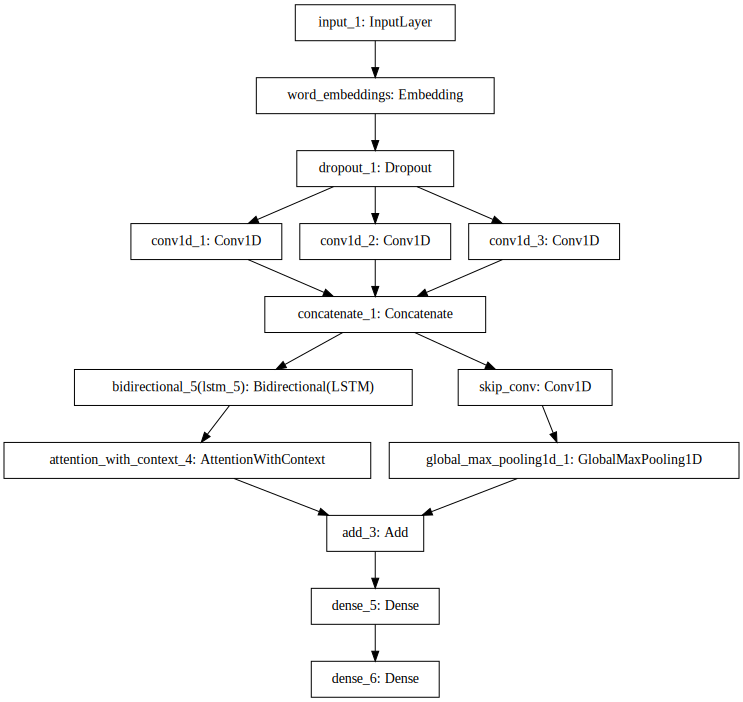

In [41]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [42]:
MODEL_NAME = 'lm_classification_imdb'
BATCH_SIZE = 1024
EPOCHS = 500
FILE_PATH = "data/training_model.hdf5"
checkpoint = ModelCheckpoint(FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=10)
tensorboard = TensorBoard(log_dir='/home/ml-notebooks/models/tensorboard/{}'.format(MODEL_NAME), 
                          batch_size=BATCH_SIZE)
callbacks_list = [checkpoint, early]

In [49]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
          validation_data=[X_val, y_val],
          callbacks=callbacks_list)

Train on 23750 samples, validate on 1250 samples
Epoch 1/500
23552/23750 [============================>.] - ETA: 0s - loss: 0.9598 - acc: 0.8051
Epoch 00001: val_loss did not improve
23750/23750 [==============================] - 21s 887us/step - loss: 0.9560 - acc: 0.8058 - val_loss: 0.5779 - val_acc: 0.8680
Epoch 2/500
23552/23750 [============================>.] - ETA: 0s - loss: 0.3826 - acc: 0.9151
Epoch 00002: val_loss did not improve
23750/23750 [==============================] - 19s 814us/step - loss: 0.3822 - acc: 0.9153 - val_loss: 0.4122 - val_acc: 0.9016
Epoch 3/500
23552/23750 [============================>.] - ETA: 0s - loss: 0.3129 - acc: 0.9431
Epoch 00003: val_loss improved from 0.40375 to 0.39473, saving model to data/training_model.hdf5
23750/23750 [==============================] - 21s 886us/step - loss: 0.3131 - acc: 0.9429 - val_loss: 0.3947 - val_acc: 0.9080
Epoch 4/500
23552/23750 [============================>.] - ETA: 0s - loss: 0.2926 - acc: 0.9497
Epoch 0000

In [50]:
model = load_model(FILE_PATH, custom_objects={'AttentionWithContext':AttentionWithContext})

In [51]:
model = load_model(FILE_PATH, custom_objects={'AttentionWithContext':AttentionWithContext})
y_hat = model.predict(X_test)
y_hat = y_hat[:,1] 

In [54]:
print('Accuracy: {}'.format(accuracy_score(y_test[:,1], y_hat > 0.5)))
print('Confusion Matrix: ')
print(confusion_matrix(y_test[:,1], y_hat > 0.5))
print(classification_report(y_test[:,1], y_hat > 0.5))

Accuracy: 0.91232
Confusion Matrix: 
[[11380  1120]
 [ 1072 11428]]
             precision    recall  f1-score   support

          0       0.91      0.91      0.91     12500
          1       0.91      0.91      0.91     12500

avg / total       0.91      0.91      0.91     25000



In [44]:
model.layers

### Unfreeze and Retrain
Once the model stops learning, we can unfreeze some of the layers and then retrain again.  This process works better than unfreezing everything at once. If you want to learn more check out the fast.ai blog and video on [ULMFiT](http://nlp.fast.ai/).

In [48]:
for layer in model.layers[-3]:
    layer.trainable = True

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
          validation_data=[X_val, y_val],
          callbacks=callbacks_list)

### Custom Attention

This is a custom Keras layer for Attention on an LSTM.  It's adapted from a gist by [cbaziotis](https://gist.github.com/cbaziotis/6428df359af27d58078ca5ed9792bd6d), and designed to create a single feature vector from a seqeuence.  You'll have to load this cell before you can use the AttentionWithContext layer in the model.

In [26]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.

    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.

    Note: The layer has been tested with Keras 2.0.6

    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]